<a href="https://colab.research.google.com/github/mittalsaurab/FakeCurrencyRecognition/blob/master/2000NoteDataTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive/Colab\ Notebooks/FakeCurrencyIdentification

/content/drive/My Drive/Colab Notebooks/FakeCurrencyIdentification


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

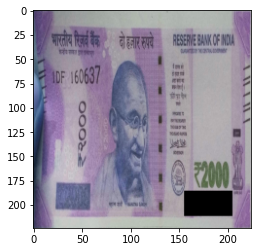

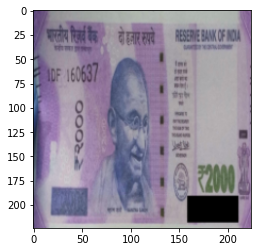

In [5]:
# checking out the basic functionality

img1 = cv2.imread('Duplicate Notes 2000/Duplicate_1.jpg')
img2 = cv2.imread('Real Notes 2000/Real_1.jpg')
# converting to HSV-scale
img1 = cv2.resize(img1, (224, 224), interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2, (224, 224), interpolation = cv2.INTER_AREA)
noOfCols = 224
noOfRows = 224

plt.imshow(img1)
plt.show()
step = 0.030
srcPoints = np.float32([[int(step*(noOfCols-1)),int(step*(noOfRows-1))], [int((1-step)*(noOfCols-1)),int(step*(noOfRows-1))], [int(step*(noOfCols-1)),int((1-step)*(noOfRows-1))], [int((1-step)*(noOfCols-1)), int((1-step)*(noOfRows-1))]])
dstPoints = np.float32([[0,0], [noOfCols-1,0], [0,noOfRows-1], [noOfCols-1,noOfRows-1]]) 
projective_matrix = cv2.getPerspectiveTransform(srcPoints, dstPoints)
imgZoomed = cv2.warpPerspective(img1, projective_matrix, (noOfCols,noOfRows))
cv2.imwrite('zoomed.jpg', imgZoomed)

plt.imshow(imgZoomed)
plt.show()
# cv2.waitKey()
# similarly, images can be written using the function imwrite and with the same arguments

In [6]:
# for efficient memory storage :
# since the numbers are between 0 and 255, numpy's int16 datatype can be used
# secondly, we need to flatten the image array to store it efficiently ad row-major
# so for that, we will numpy's use numpy's ravel function with 'copy' flag = False
def generateDataForImages():
    """
    In this function, various techniques for augementing image data, such as random rotations
    and translations, zooming on images will performed to produce a dataset of size ~1600 images.
    RETURN :
        a list of 2-tuples where the first element in each tuple is an image's numpy 2-D array 
        and the second label is the corresponding label, 1 for real note and 0 for fake note
    """
    
    # this will be the function used to resize and grayscale the the raw input image
    def resizeGrayCenter(img):
        img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
        # img = img - img.mean()
        return img
    def perCentreMean(img):
      # img = np.swapaxes(np.swapaxes(img, 1, 2), 0, 1)
      # img = img - IMAGE_MEAN
      return img
    
    # a list of 2-tuples to hold an image's numpy 2-D array 
    # and the corresponding label, 1 for real and 0 for fake
    trainingData = []
    noOfRows = 224
    noOfCols = 224
    
    # first all real currency notes' images and then all the fake ones'
    # i am skeptical of the consequences :-/
    label = 1
    
    for directory in ['Real Notes 2000/', 'Duplicate Notes 2000/']:
        for filename in os.listdir(directory):
            # print filename
            img = cv2.imread(directory + filename)
            img = resizeGrayCenter(img)
            # print(img.shape)
            # TRANSLATIONS
            # will produce (6 + 6 + 1) x (6 + 6 + 1) = 169 images
            # stride of 5 pixels along both axis along all 4 directions
            for x in range(30, -35, -5):
                for y in range(30, -35, -5):
                    translationMatrix = np.float32([ [1,0,x], [0,1,y] ])
                    imgTrns = cv2.warpAffine(img, translationMatrix, (noOfCols, noOfRows))
                    # trainingData.append((np.ravel(imgTrns.astype(np.int16, copy = False)), label))
                    trainingData.append((imgTrns,label))

            # ROTATIONS
            # we produce 41 different angles in the range of -10 to 10
            # with the step being equal to 0.5
            for angle in range(20, -21, -1):
                rotationMatrix = cv2.getRotationMatrix2D((noOfCols/2, noOfRows/2), float(angle)/2, 1)
                imgRotated = cv2.warpAffine(img, rotationMatrix, (noOfCols, noOfRows))
                # imgRotated = perCentreMean(imgRotated)
                # trainingData.append((np.ravel(imgRotated.astype(np.int16, copy = False)), label))
                trainingData.append((imgRotated,label))

            # PROJECTIVE TRANSFORMATIONS for ZOOMING IN AND ZOOMING OUT
            # will produce (30 + 30) images for the dataset
            # 1ST ZOOMING IN ...
            for step in np.arange(0.001, 0.031, 0.001):
                srcPoints = np.float32([[int(step*(noOfCols-1)),int(step*(noOfRows-1))], [int((1-step)*(noOfCols-1)),int(step*(noOfRows-1))], [int(step*(noOfCols-1)),int((1-step)*(noOfRows-1))], [int((1-step)*(noOfCols-1)), int((1-step)*(noOfRows-1))]])
                dstPoints = np.float32([[0,0], [noOfCols-1,0], [0,noOfRows-1], [noOfCols-1,noOfRows-1]]) 
                projective_matrix = cv2.getPerspectiveTransform(srcPoints, dstPoints)
                imgZoomed = cv2.warpPerspective(img, projective_matrix, (noOfCols,noOfRows))
                # trainingData.append((np.ravel(imgZoomed.astype(np.int16, copy = False)), label))
                trainingData.append((imgZoomed,label))

            # 2ND ZOOMING OUT ...
            for step in np.arange(0.001, 0.031, 0.001):
                srcPoints = np.float32(np.float32([[0,0], [noOfCols-1,0], [0,noOfRows-1], [noOfCols-1,noOfRows-1]]))
                dstPoints = np.float32([[int(step*(noOfCols-1)),int(step*(noOfRows-1))], [int((1-step)*(noOfCols-1)),int(step*(noOfRows-1))], [int(step*(noOfCols-1)),int((1-step)*(noOfRows-1))], [int((1-step)*(noOfCols-1)), int((1-step)*(noOfRows-1))]]) 
                projective_matrix = cv2.getPerspectiveTransform(srcPoints, dstPoints)
                imgZoomed = cv2.warpPerspective(img, projective_matrix, (noOfCols,noOfRows))
                trainingData.append((imgZoomed,label))
                # trainingData.append((np.ravel(imgZoomed.astype(np.int16, copy = False)), label))
        # set label for fake images to come
        label = 0
            
    return trainingData

In [7]:
imagesAndLabels = generateDataForImages()
print(imagesAndLabels[0][0].shape)
# imagesAndLabels = 10*imagesAndLabels
# now shuffle this data so that real and fake images are scattered in the dataset
from numpy.random import shuffle
shuffle(imagesAndLabels)

(224, 224, 3)


In [8]:
print(len(imagesAndLabels))

1620


In [9]:
# dividing in the ratio of 0.7, 0.2, 0.1 for training, validation and test
trainingData = imagesAndLabels[:1134]
validationData = imagesAndLabels[1134:1458]
testData = imagesAndLabels[1458:]

Xtrain,ytrain = [],[]
Xval, yval = [],[]
Xtest, ytest = [],[]

for i in range(len(trainingData)):
    Xtrain.append(trainingData[i][0])
    ytrain.append(trainingData[i][1])

for i in range(len(validationData)):
    Xval.append(validationData[i][0])
    yval.append(validationData[i][1])

for i in range(len(testData)):
    Xtest.append(testData[i][0])
    ytest.append(testData[i][1])
    

# trainData = (trainingInput, trainingOutput)
# validData = (validationInput, validationOutput)
# testData = (testInput, testOutput)

# dataset = (trainData, validationData, testData)
# import cPickle
# with open('fakeCurrencyDetectionData.pkl','wb') as fp:
#     cPickle.dump(dataset,fp, protocol = 2)

In [10]:
Xtrain = np.array(Xtrain)
# Xval = np.array(Xval)
Xtest = np.array(Xtest)


In [11]:
ytrain = np.array(ytrain)
# yval = np.array(yval)
ytest = np.array(ytest)


In [12]:
from keras.utils import to_categorical


ytrain = to_categorical(ytrain)

print(Xtrain.shape)

# yval = to_categorical(yval)

# print(yval.shape)

(1134, 224, 224, 3)


Training Part

In [13]:
from keras.applications import vgg16
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten,Input,GlobalAveragePooling2D,Dropout
from keras.optimizers import Adam

In [14]:
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224,3))
len(vgg_conv.layers)

58892288/58889256 [==============================] - 1s 0us/step


19

In [15]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
for layer in vgg_conv.layers[:]:
    layer.trainable = False


In [17]:
l2 = GlobalAveragePooling2D()(vgg_conv.output)
l3 = Dense(256,activation='relu')(l2)
l4 = Dropout(0.5)(l3)
l5 = Dense(2,activation='softmax')(l4)

final_model = Model(vgg_conv.input,l5)

In [18]:
# final_model.summary()

In [19]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau


In [20]:
rr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr = 0.00000001)
# er = EarlyStopping(monitor='val_loss',patience = 4,verbose=1)
mc = ModelCheckpoint("model_weights.hdf5",monitor='val_acc',save_best_only=True,period=1)

In [21]:
adam = Adam(lr=0.0003)
final_model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [22]:
hist = final_model.fit(Xtrain,ytrain,epochs = 10, batch_size = 16,callbacks=[mc,rr])


Epoch 1/10
71/71 [==============================] - 5s 66ms/step - loss: 0.5199 - accuracy: 0.8677
Epoch 2/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0139 - accuracy: 0.9956
Epoch 3/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0042 - accuracy: 0.9982
Epoch 4/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0028 - accuracy: 0.9991
Epoch 5/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0059 - accuracy: 0.9982
Epoch 6/10
71/71 [==============================] - 4s 57ms/step - loss: 8.6338e-04 - accuracy: 1.0000
Epoch 7/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 8/10
71/71 [==============================] - 4s 57ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 9/10
71/71 [==============================] - 4s 58ms/step - loss: 0.0022 - accuracy: 0.9982
Epoch 10/10
71/71 [==============================] - 4s 58ms/step - loss: 2.6701e-04 - accuracy: 1.0000


In [30]:
print("Accuracy on Test Dataset is : " + str(final_model.evaluate(Xtest,Ytest)[1])); 


6/6 [==============================] - 0s 83ms/step - loss: 5.1465e-06 - accuracy: 1.0000
Accuracy on Test Dataset is : 1.0


In [25]:
final_model.save_weights("2000_model.hdf5");
Ytest = to_categorical(ytest);

6/6 [==============================] - 1s 135ms/step - loss: 5.1465e-06 - accuracy: 1.0000
Accuracy on Test Dataset is : 1.0


Actual :Fake
Predicted :Fake


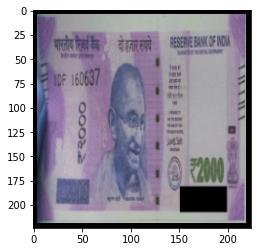

In [27]:
def decide(x):
  if x:
    return "Real"
  else:
    return "Fake"


r = np.random.randint(1100)
plt.imshow(Xtrain[r])
print("Actual :" + decide(np.argmax(ytrain[r])))
print("Predicted :" + decide(np.argmax(final_model.predict(Xtrain[r:r+1])[0])))

In [28]:
import sklearn.metrics as metrics
confusion_matrix = metrics.confusion_matrix(ytrain.argmax(axis=1), final_model.predict(Xtrain).argmax(axis=1))

In [29]:
print("Confusion matrix for 2000 notes : ")
print(confusion_matrix)

Confusion matrix for 2000 notes : 
[[571   0]
 [  0 563]]
